In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

import unicodedata
import string

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [8]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) \
            if unicodedata.category(c) != 'Mn' and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [9]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(n_categories, all_categories)

18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [10]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [12]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [13]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = torch.nn.Linear(input_size + hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [14]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [15]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9625, -2.8496, -2.8078, -2.8908, -2.8321, -2.9599, -2.9222, -2.8482,
         -2.8266, -2.9193, -2.9604, -2.8682, -2.8509, -2.9521, -2.8835, -2.9476,
         -2.9086, -2.8589]], grad_fn=<LogSoftmaxBackward>)


In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9625, -2.8496, -2.8078, -2.8908, -2.8321, -2.9599, -2.9222, -2.8482,
         -2.8266, -2.9193, -2.9604, -2.8682, -2.8509, -2.9521, -2.8835, -2.9476,
         -2.9086, -2.8589]], grad_fn=<LogSoftmaxBackward>)


In [17]:
print(categoryFromOutput(output))

('Arabic', 2)


In [18]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Specht
category = Portuguese / line = Ramires
category = German / line = Michel
category = Arabic / line = Said
category = Italian / line = Napoleoni
category = Scottish / line = Cunningham
category = Irish / line = O'Driscoll
category = Spanish / line = Arriola
category = English / line = Duffy
category = Russian / line = Makhutov


In [19]:
criterion = torch.nn.NLLLoss()

In [20]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

In [27]:
import time
import math

n_iters = 400000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  app.launch_new_instance()


5000 1% (0m 10s) 2.9649 Konig / Chinese ✗ (German)
10000 2% (0m 20s) 1.8878 Palmeiro / Portuguese ✓
15000 3% (0m 30s) 2.1814 Castillo / Italian ✗ (Spanish)
20000 5% (0m 39s) 0.4273 Rudaski / Polish ✓
25000 6% (0m 49s) 0.2940 Kowalski / Polish ✓
30000 7% (0m 58s) 1.5058 Beaulieu / French ✓
35000 8% (1m 8s) 2.1763 Murphy / Japanese ✗ (Scottish)
40000 10% (1m 17s) 1.2663 Boucher / French ✓
45000 11% (1m 27s) 1.1260 D'antonio / Italian ✓
50000 12% (1m 37s) 3.0341 Chaim / Korean ✗ (Chinese)
55000 13% (1m 49s) 0.4068 Paterson / Scottish ✓
60000 15% (2m 0s) 4.6700 Jamussa / Japanese ✗ (Greek)
65000 16% (2m 11s) 0.1931 Drivakis / Greek ✓
70000 17% (2m 20s) 1.3454 Chlebek / Czech ✗ (Polish)
75000 18% (2m 29s) 0.8418 Tailler / French ✓
80000 20% (2m 39s) 2.5899 Shima / Japanese ✗ (Czech)
85000 21% (2m 49s) 0.3116 Yoshizawa / Japanese ✓
90000 22% (2m 59s) 1.1387 Espina / Italian ✗ (Spanish)
95000 23% (3m 10s) 0.9922 Smeets / Dutch ✓
100000 25% (3m 20s) 0.0437 Chijikov / Russian ✓
105000 26% (3m 3

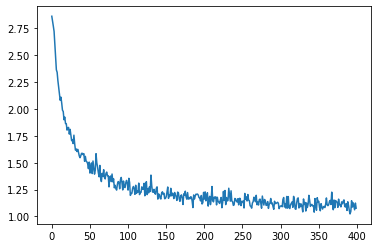

In [28]:
plt.figure()
plt.plot(all_losses)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


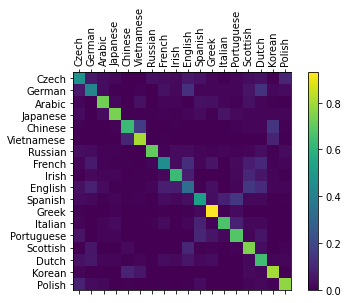

In [29]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.61) Czech
(-0.96) Russian
(-3.30) English

> Jackson
(-0.56) Scottish
(-1.01) English
(-3.72) Russian

> Satoshi
(-0.87) Japanese
(-1.82) Italian
(-2.41) Arabic
